In [173]:
import pandas
import numpy as np
import csv

<h1>Prepping the Data</h1>

<p>Getting rid of all unneccessary data to train the model</p>

In [174]:
data = pandas.read_csv("./archive/spreadspoke_scores.csv")

#Getting rid of unneccessary data such as team wins before 2010
exclude = data["schedule_season"] < 2010
data = data[~exclude]

#Getting rid of all future games, will use this later
future = data[data["score_home"].isnull()]
data.dropna(subset=["score_home","score_away","team_home","team_away"], inplace=True)


print(data)


      schedule_date  schedule_season schedule_week  schedule_playoff  \
10008      9/9/2010             2010             1             False   
10009     9/12/2010             2010             1             False   
10010     9/12/2010             2010             1             False   
10011     9/12/2010             2010             1             False   
10012     9/12/2010             2010             1             False   
...             ...              ...           ...               ...   
13647     11/5/2023             2023             9             False   
13648     11/5/2023             2023             9             False   
13649     11/5/2023             2023             9             False   
13650     11/5/2023             2023             9             False   
13651     11/6/2023             2023             9             False   

                  team_home  score_home  score_away              team_away  \
10008    New Orleans Saints        14.0         9.0      

In [175]:
team_won = np.where(data["score_home"] > data["score_away"], data["team_home"], data["team_away"])

In [176]:
print(data["team_away"].unique())

['Minnesota Vikings' 'Miami Dolphins' 'Detroit Lions' 'Indianapolis Colts'
 'Denver Broncos' 'Cincinnati Bengals' 'Carolina Panthers'
 'Green Bay Packers' 'Atlanta Falcons' 'San Francisco 49ers'
 'Arizona Cardinals' 'Cleveland Browns' 'Oakland Raiders' 'Dallas Cowboys'
 'San Diego Chargers' 'Baltimore Ravens' 'Tampa Bay Buccaneers'
 'Kansas City Chiefs' 'Chicago Bears' 'Seattle Seahawks'
 'Philadelphia Eagles' 'Buffalo Bills' 'New York Giants'
 'New England Patriots' 'St. Louis Rams' 'Jacksonville Jaguars'
 'Pittsburgh Steelers' 'Houston Texans' 'New Orleans Saints'
 'New York Jets' 'Tennessee Titans' 'Washington Redskins'
 'Los Angeles Rams' 'Los Angeles Chargers' 'Las Vegas Raiders'
 'Washington Football Team' 'Washington Commanders']


<p>Splitting the data into Test, Validate, and Train data</p>

In [177]:
def getTeamElos(data):
    teams = dict()
    ret = {
        "team" : [],
        "elo" : [],
        "date" : []
    }

    def calculateNewTeamElos(game, isHome) -> pandas.DataFrame:
        home = game["team_home"] 
        away = game["team_away"] 
        teamWon = game["team_home"] if game["score_home"] > game["score_away"] else game["team_away"]
        teamLoss = game["team_away"] if game["score_home"] > game["score_away"] else game["team_home"]
        
        sHomeTeam = 0
        sAwayTeam = 1

        if game["score_home"] > game["score_away"]:
            sHomeTeam = 1.0
            sAwayTeam = 0
        elif game["score_home"] > game["score_away"]:
            sHomeTeam = 0.5
            sAwayTeam = 0.5
        

        #this is probably wrong
        def getMarginOfVictoryMultiplier() -> float:
            eloDifferenceWinner = teams[teamWon] - teams[teamLoss]
            pointDifferenceWinner = abs(game["score_home"] - game["score_away"])
            #print(np.log(pointDifferenceWinner + 1) * (22/(eloDifferenceWinner*0.001+2.2)))
            return np.log(pointDifferenceWinner + 1) * (22/(eloDifferenceWinner*0.001+2.2))
        
        k = (20 + getMarginOfVictoryMultiplier()) / (2024 - game["schedule_season"])
        
        def calculateEstimatedProbability(first, second) -> float:
            return 1 / (1 +  pow(10, -1 * (teams[first] - teams[second])/400) )
        
        eHomeTeam = calculateEstimatedProbability(home,away)
        eAwayTeam = calculateEstimatedProbability(away,home)

        eloHomePoints = k * (sHomeTeam - eHomeTeam)
        eloAwayPoints = k * (sAwayTeam - eAwayTeam)

        teams[home] += eloHomePoints
        teams[away] += eloAwayPoints
        
        ret["team"].append(home)
        ret["elo"].append(teams[home])
        ret["date"].append(game["schedule_date"])

        ret["team"].append(away)
        ret["elo"].append(teams[away])
        ret["date"].append(game["schedule_date"])

    for _, game in data.iterrows():
        
        if game["team_home"] not in teams:
            teams[game["team_home"]] = 1500
                
        if game["team_away"] not in teams:
            teams[game["team_away"]] = 1500
        
        calculateNewTeamElos(game, True)
        calculateNewTeamElos(game, False)

    return pandas.DataFrame.from_dict(ret)

teamElos = getTeamElos(data=data)

17.91759469228055
17.895563629666928
17.91759469228055
17.895563629666928
17.91759469228055
17.895563629666928
23.978952727983707
23.944762287440778
20.79441541679836
20.76690976926425
27.0805020110221
27.039170267186368
26.390573296152585
26.350883925627574
20.79441541679836
20.76690976926425
19.45910149055313
19.43420356163344
32.58096538021482
32.52543879024708
16.094379124341003
16.075540272223655
13.862943611198906
13.847718789104775
32.58096538021482
32.52543879024708
19.45910149055313
19.43420356163344
20.79441541679836
20.76690976926425
6.931471805599453
6.925416232482337
35.64054284266333
35.57512218004833
26.32230007345498
26.283520182630763
17.96056364825761
17.938066518989473
10.959667662963486
10.948856351255316
20.742528398694404
20.71562688177156
28.99114189844577
28.944081907269894
13.864226879185091
13.848989747993853
33.23747451646272
33.18118837562613
32.28300039955294
32.22712061760294
16.05501423464592
16.036578173839168
27.145444929908955
27.10322868608295
10.9919

In [178]:
print(teamElos)

                       team          elo       date
0        New Orleans Saints  1501.354200   9/9/2010
1         Minnesota Vikings  1498.645800   9/9/2010
2        New Orleans Saints  1502.697063   9/9/2010
3         Minnesota Vikings  1497.302937   9/9/2010
4             Buffalo Bills  1498.645800  9/12/2010
...                     ...          ...        ...
14571        Dallas Cowboys  1620.813043  11/5/2023
14572         New York Jets  1494.996332  11/6/2023
14573  Los Angeles Chargers  1540.177034  11/6/2023
14574         New York Jets  1473.103588  11/6/2023
14575  Los Angeles Chargers  1562.069777  11/6/2023

[14576 rows x 3 columns]


<Axes: >

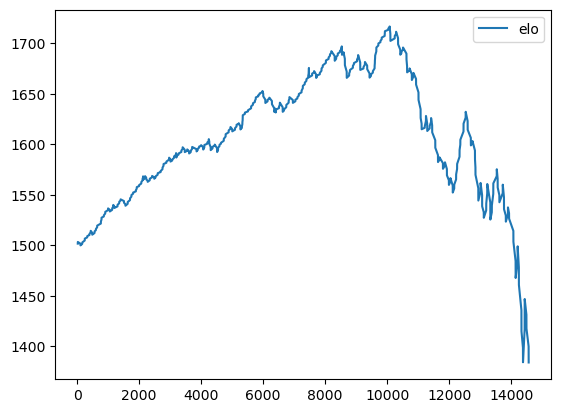

In [184]:
pats = teamElos.loc[teamElos["team"]=="New England Patriots"]
pats.plot()

/Users/hugh/anaconda3/envs/ML/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


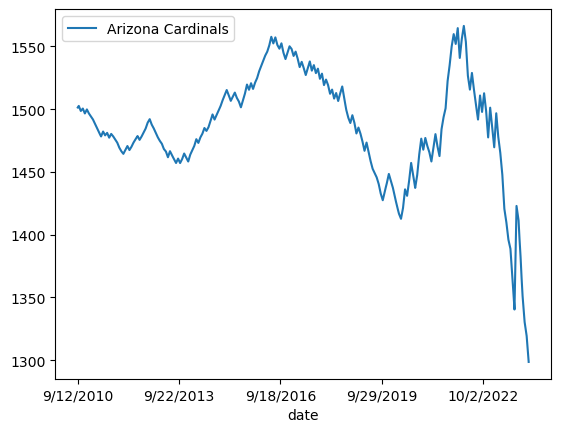

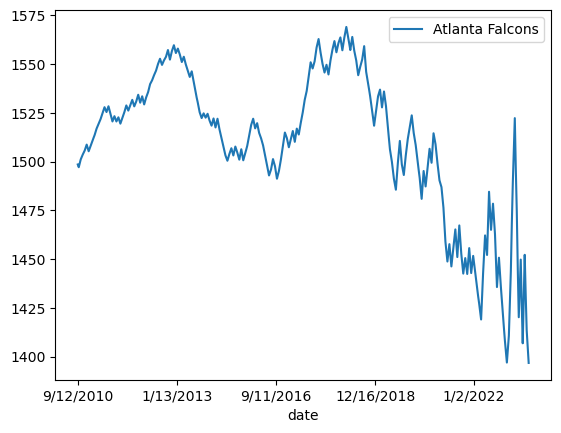

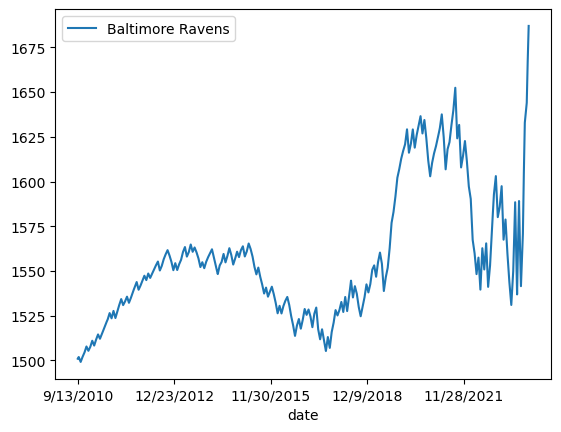

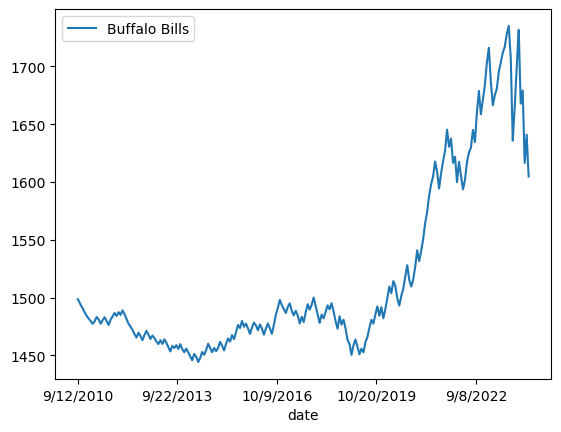

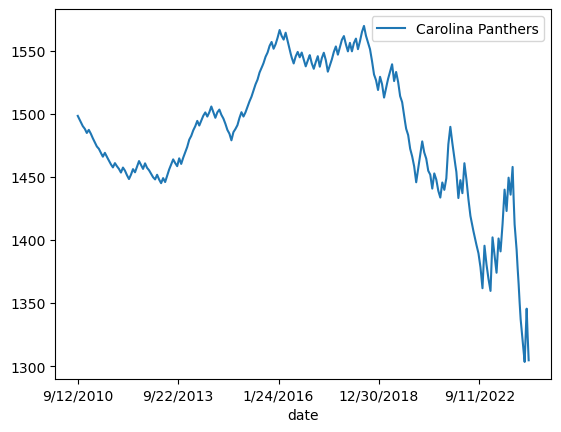

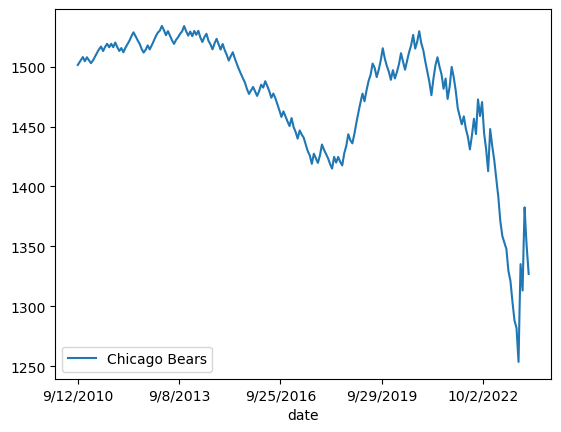

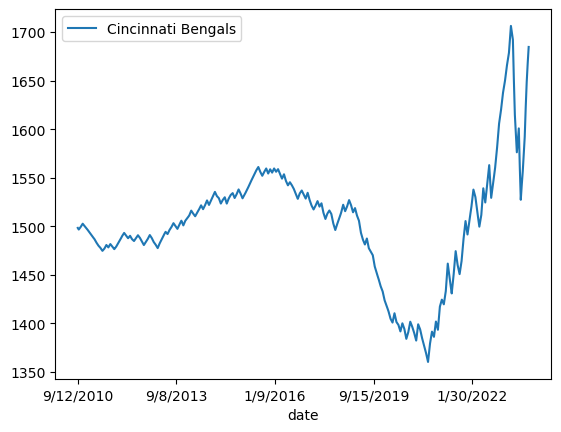

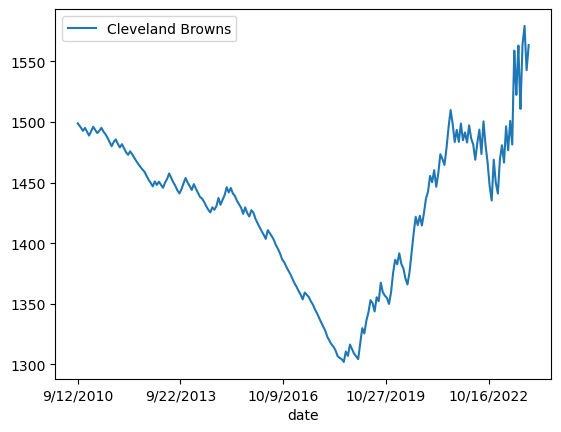

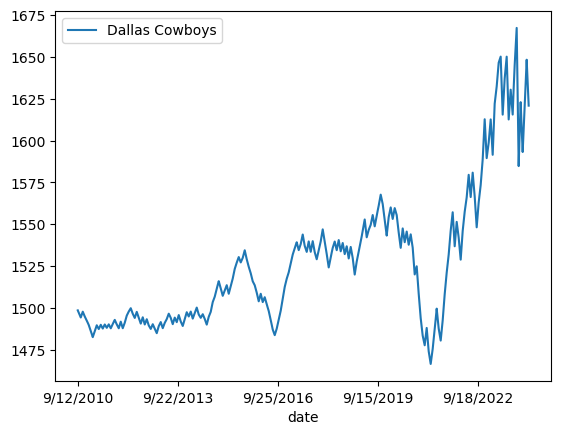

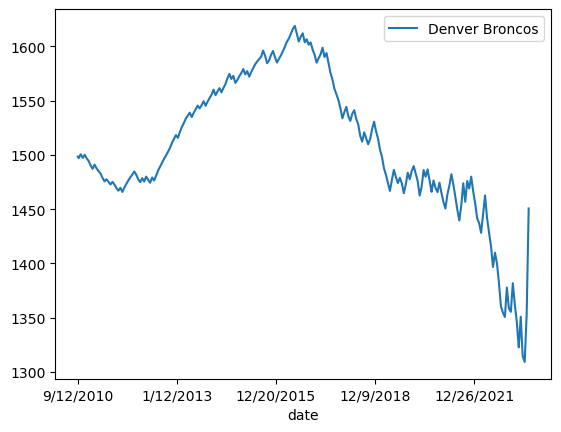

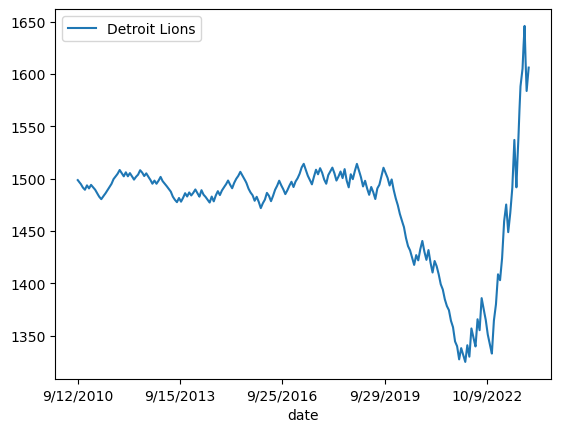

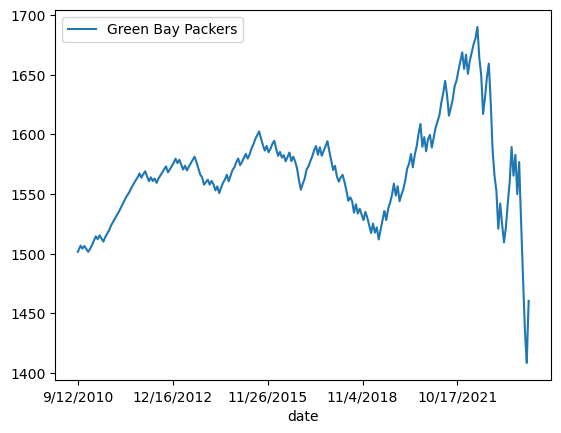

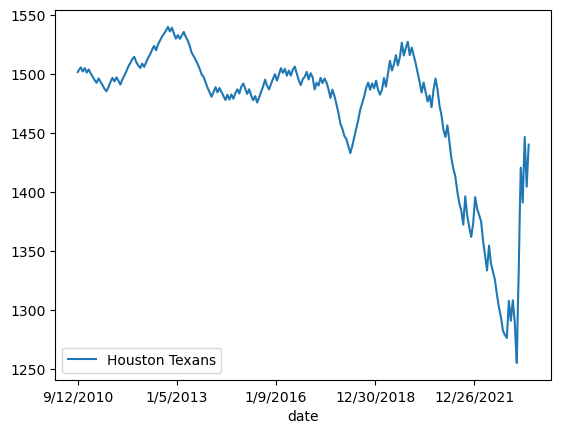

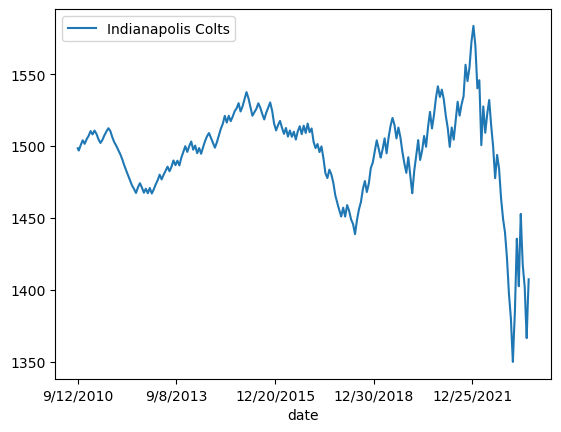

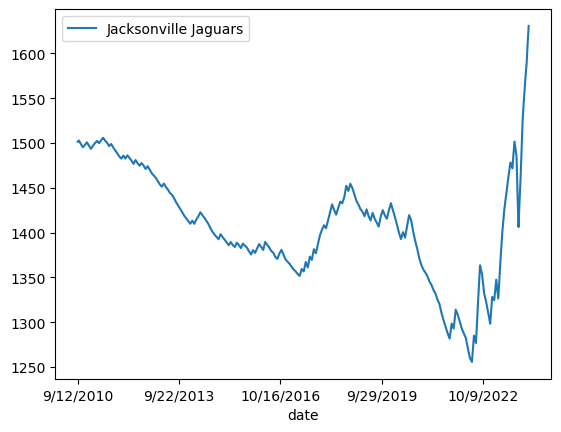

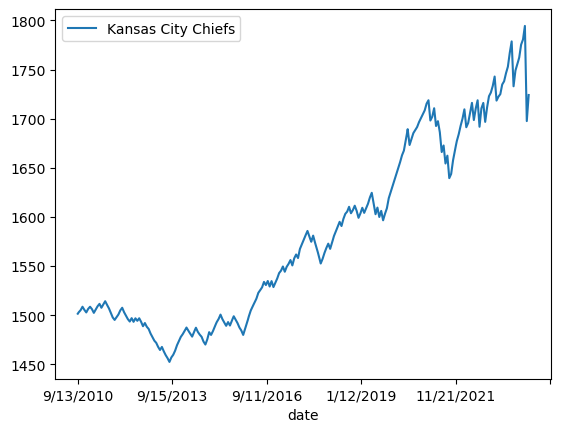

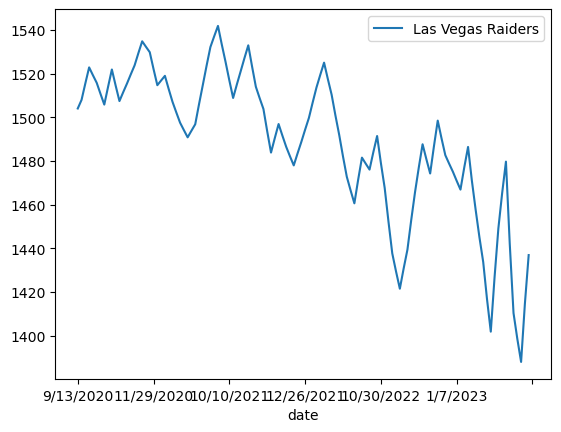

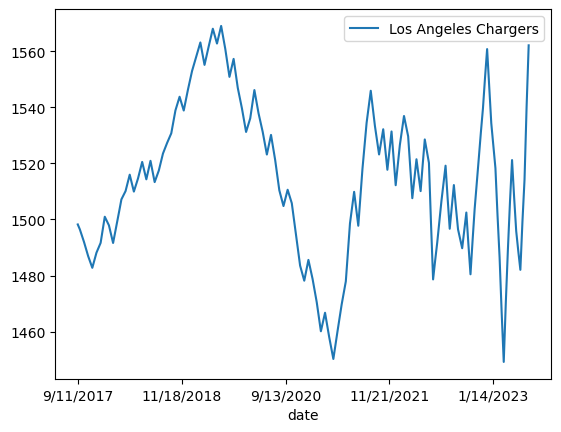

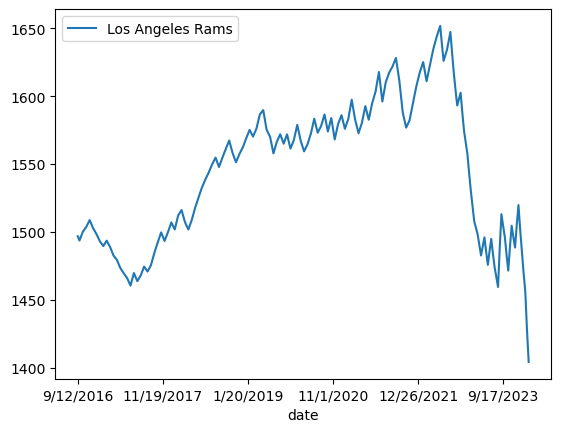

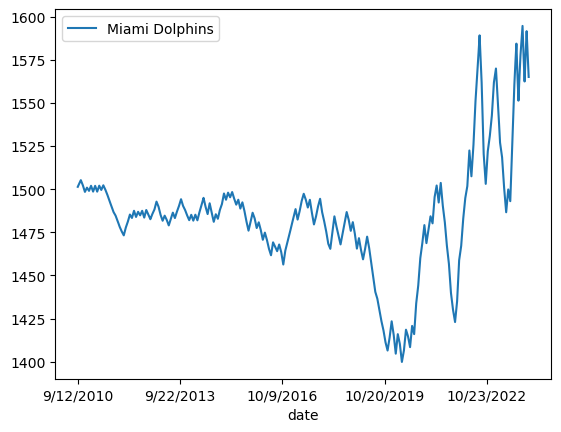

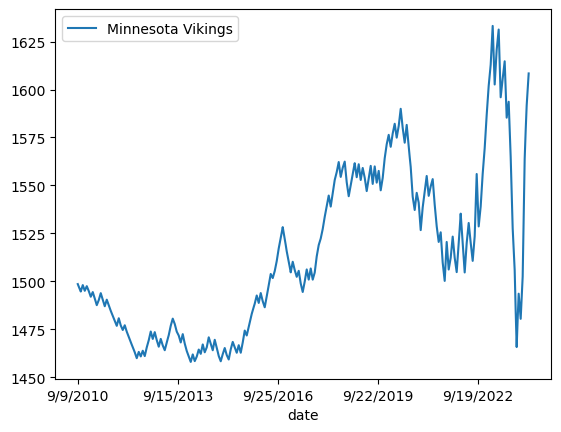

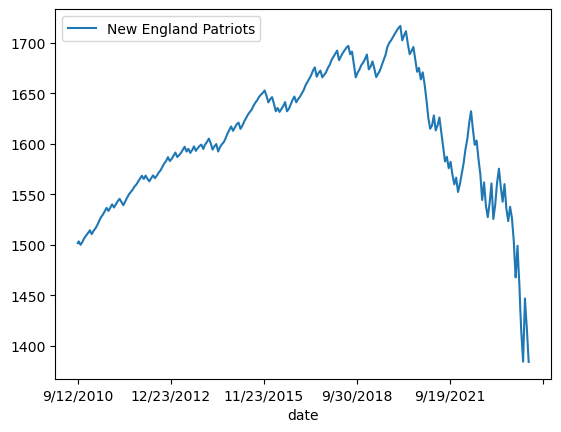

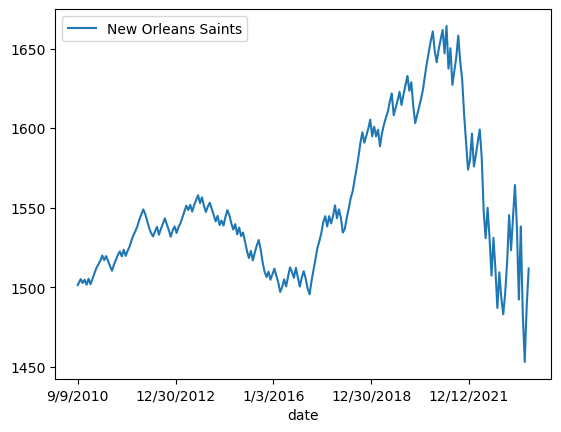

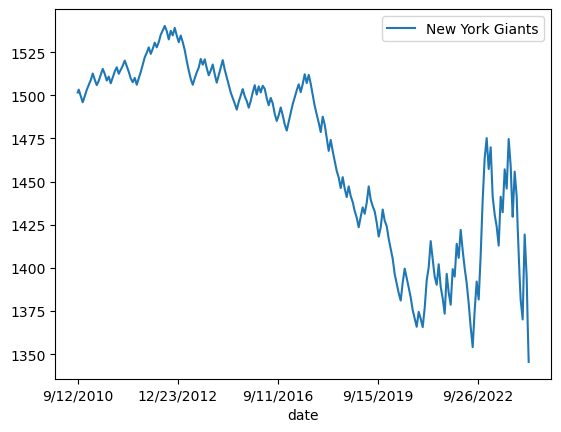

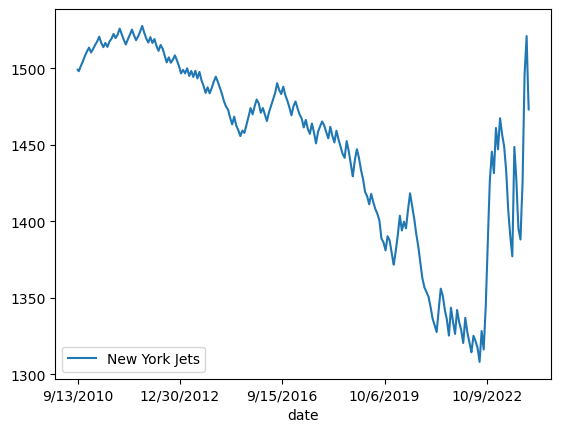

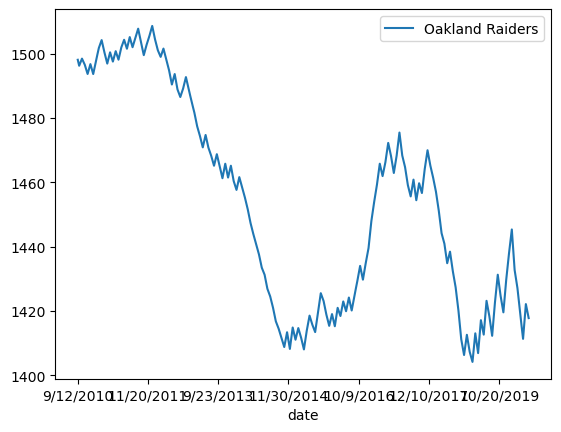

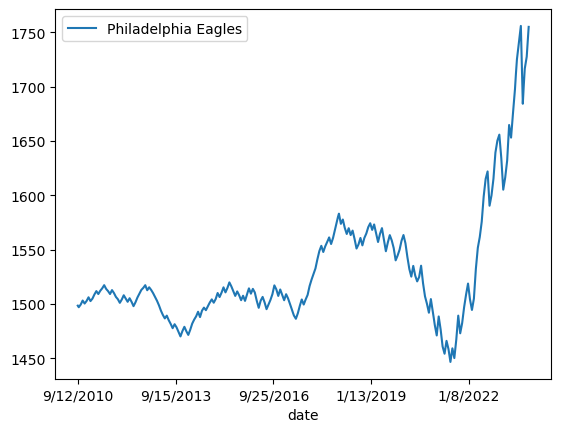

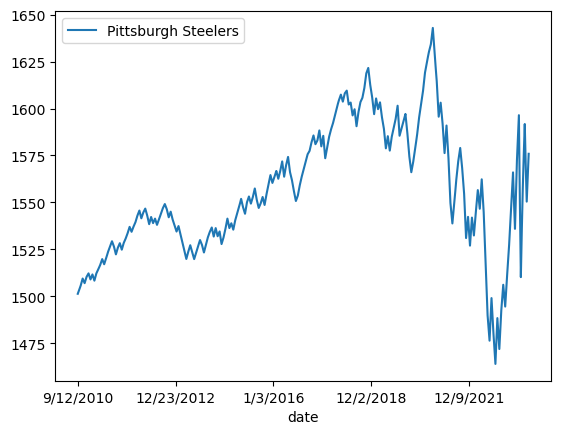

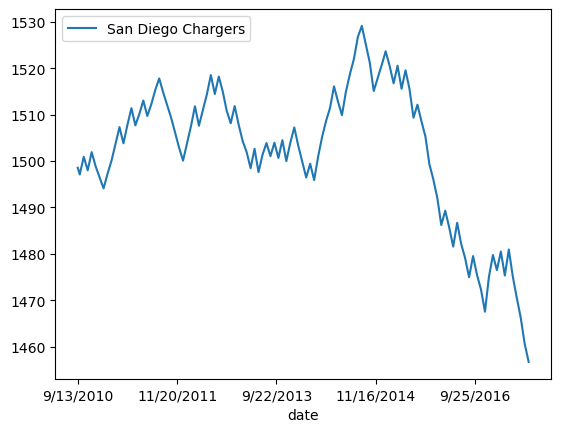

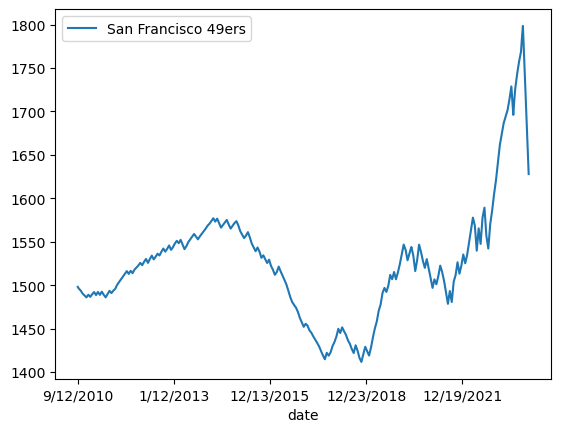

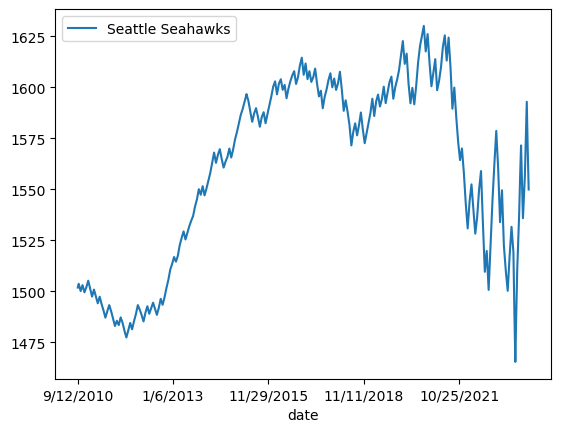

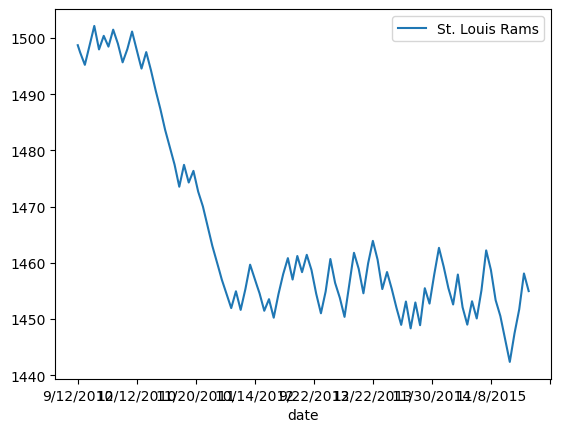

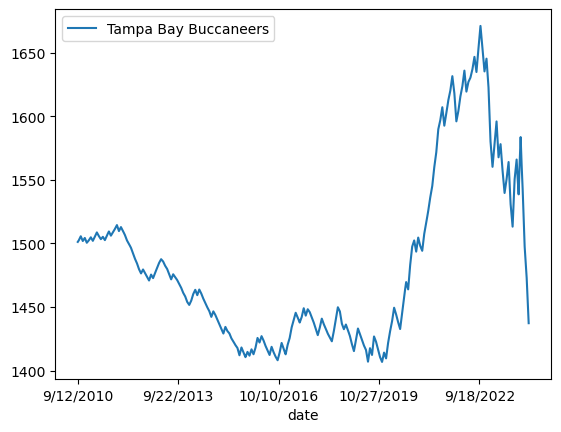

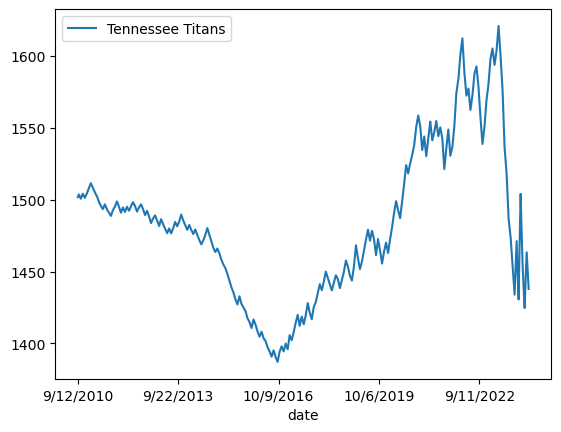

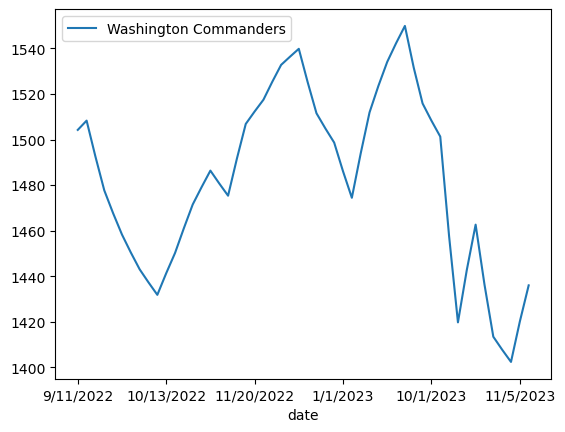

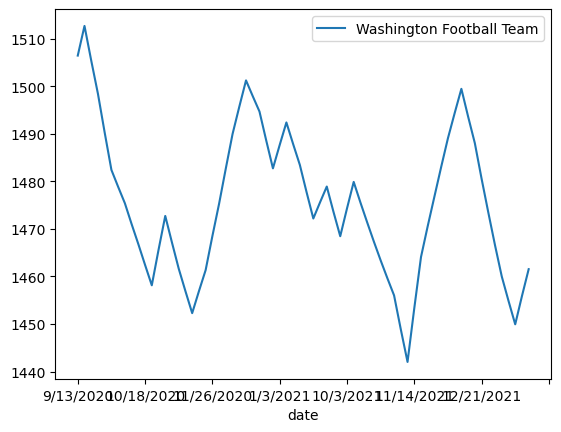

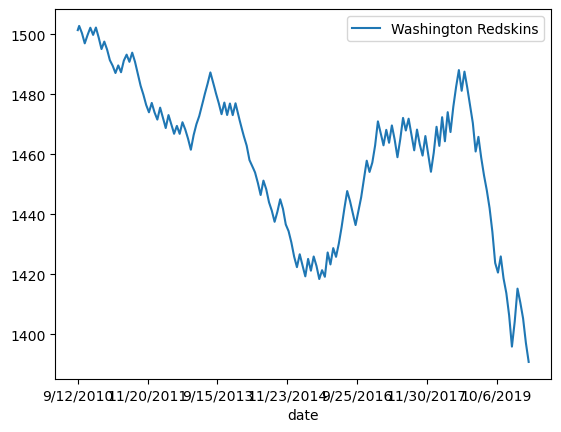

In [195]:

for label, grp in teamElos.groupby("team"):
    grp.plot(x= 'date', y="elo", label=label)